과제 1. WISDM dataset에서 CNN, LSTM, CNN-LSTM 3가지 모델로 성능 높여보기



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 모델 임포트

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

In [4]:
# 오류 검출 및 제거

file = open('/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1_raw.txt')
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

# 281873~281875번 line이 공백임

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [5]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']
df = pd.DataFrame(data = processedList, columns = columns)
df.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [6]:
df.shape

(343416, 6)

In [7]:
df.isnull().sum() # 결측치 체크

,0
user,0
activity,0
time,0
x,0
y,0
z,0


In [8]:
df['activity'].value_counts() # 데이터 분포 확인

,count
activity,
Walking,137375
Jogging,129392
Upstairs,35137
Downstairs,33358
Sitting,4599
Standing,3555


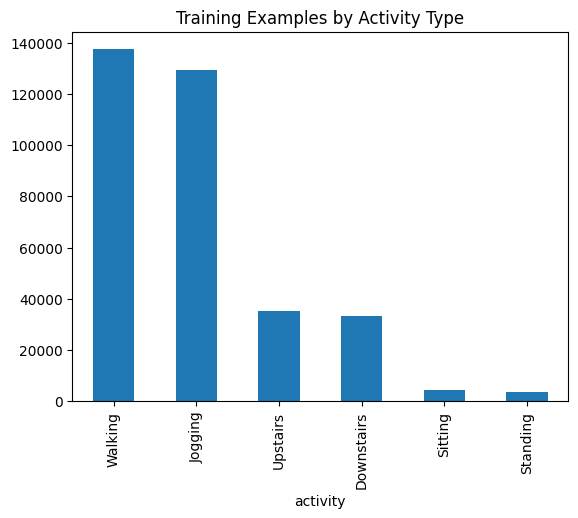

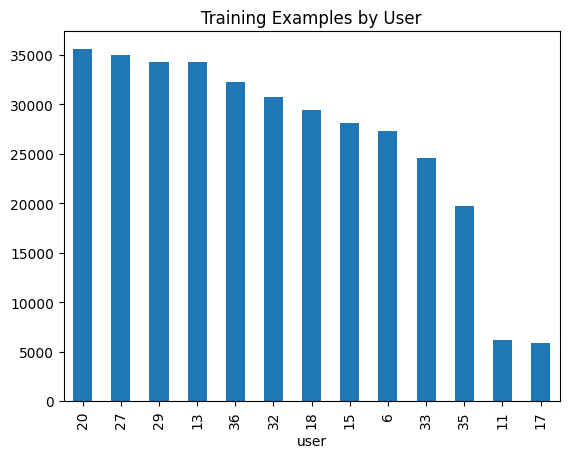

In [9]:
# 데이터 분포 시각화

# Show how many training examples exist for each of the six activities
df["activity"].value_counts().plot(kind = "bar", title = "Training Examples by Activity Type")
plt.show()
# Better understand how the recordings are spread across the different users who participated in the study
df["user"].value_counts().plot(kind = "bar", title = "Training Examples by User")
plt.show()

In [10]:
# float 타입으로 형변환

df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')

In [11]:
activities = df['activity'].value_counts().index

In [12]:
label = LabelEncoder()
df['activity'] = label.fit_transform(df['activity'])
df.head()

,user,activity,time,x,y,z
0,33,1,49105962326000,-0.694638,12.680544,0.503953
1,33,1,49106062271000,5.012288,11.264028,0.953424
2,33,1,49106112167000,4.903325,10.882658,-0.081722
3,33,1,49106222305000,-0.612916,18.496431,3.023717
4,33,1,49106332290000,-1.184970,12.108489,7.205164


In [13]:
activities

Index(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'], dtype='object', name='activity')

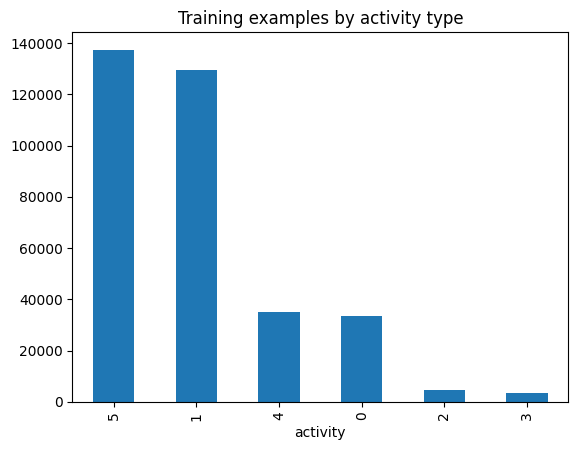

In [14]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [15]:
num_classes = 6 # activity 개수

In [16]:
from sklearn import preprocessing

# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())

In [17]:
X = df[['x', 'y', 'z']]
y = df['ActivityEncoded']

In [18]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X

,x,y,z,label
0,-0.258214,0.697059,0.044419,1
1,0.607502,0.483225,0.145310,1
2,0.590972,0.425654,-0.087046,1
3,-0.245817,1.575011,0.610023,1
4,-0.332596,0.610703,1.548620,1
...,...,...,...,...
343411,-0.105815,0.402609,-0.059530,5
343412,0.265839,0.435820,0.120852,5
343413,-0.031484,0.315054,0.230915,5
343414,-0.391003,0.094656,0.249259,5


In [19]:
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

In [20]:
_size = Fs*4 # 프레임의 길이
hop_size = Fs*2 # 프레임 간 이동 간격
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3 # 특징 개수(x, y, z)

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]

        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size], keepdims = True).mode[0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [21]:
X, y = get_frames(scaled_X, frame_size, hop_size)


In [22]:
X.shape, y.shape

((8584, 80, 3), (8584,))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [24]:
X_train.shape, X_test.shape

((6867, 80, 3), (1717, 80, 3))

In [25]:
X_train[0].shape, X_test[0].shape

((80, 3), (80, 3))

In [26]:
X_train = X_train.reshape(6867, 80, 3, 1)
X_test = X_test.reshape(1717, 80, 3, 1)

In [27]:
X_train[0].shape, X_test[0].shape

((80, 3, 1), (80, 3, 1))

In [28]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

## CNN Model

In [29]:
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax'),
])
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 78, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 39, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 37, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,158 (1.23 MB)

 Trainable params: 321,158 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
cnn_history = cnn_model.fit(X_train, y_train, epochs = 30, validation_split = 0.2, verbose=1)

Epoch 1/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.7133 - loss: 0.7741 - val_accuracy: 0.8996 - val_loss: 0.3201
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8953 - loss: 0.2835 - val_accuracy: 0.9229 - val_loss: 0.1994
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9278 - loss: 0.2004 - val_accuracy: 0.9381 - val_loss: 0.1841
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9551 - loss: 0.1277 - val_accuracy: 0.9491 - val_loss: 0.1604
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9718 - loss: 0.0863 - val_accuracy: 0.9512 - val_loss: 0.1429
Epoch 6/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9795 - loss: 0.0628 - val_accuracy: 0.9527 - val_loss: 0.1390
Epoch 7/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9884 - loss: 0.0391 - val_accuracy: 0.9600 - val_loss: 0.1363
Epoch 8/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9879 - loss: 0.0414 - val_accuracy: 0

In [32]:
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

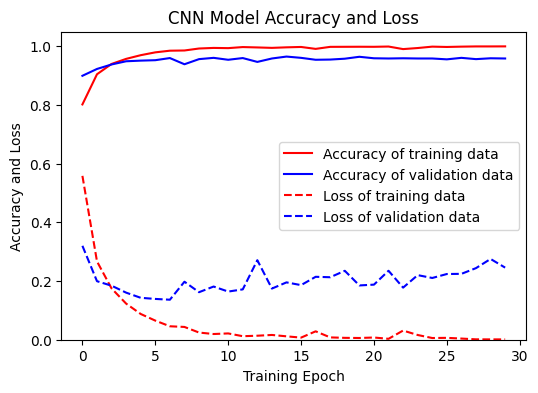

In [33]:
plt.figure(figsize=(6, 4))
plt.plot(cnn_history.history["accuracy"], 'r', label = "Accuracy of training data")
plt.plot(cnn_history.history["val_accuracy"], 'b', label = "Accuracy of validation data")
plt.plot(cnn_history.history["loss"], 'r--', label = "Loss of training data")
plt.plot(cnn_history.history["val_loss"], 'b--', label = "Loss of validation data")
plt.title("CNN Model Accuracy and Loss")
plt.ylabel("Accuracy and Loss")
plt.xlabel("Training Epoch")
plt.ylim(0)
plt.legend()
plt.show()

In [34]:
predicted = cnn_model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


              precision    recall  f1-score   support

           0       0.91      0.89      0.90       167
           1       0.98      0.99      0.99       646
           2       0.95      0.91      0.93        23
           3       1.00      0.94      0.97        18
           4       0.93      0.87      0.90       176
           5       0.98      0.99      0.98       687

    accuracy                           0.97      1717
   macro avg       0.96      0.93      0.95      1717
weighted avg       0.97      0.97      0.97      1717



(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

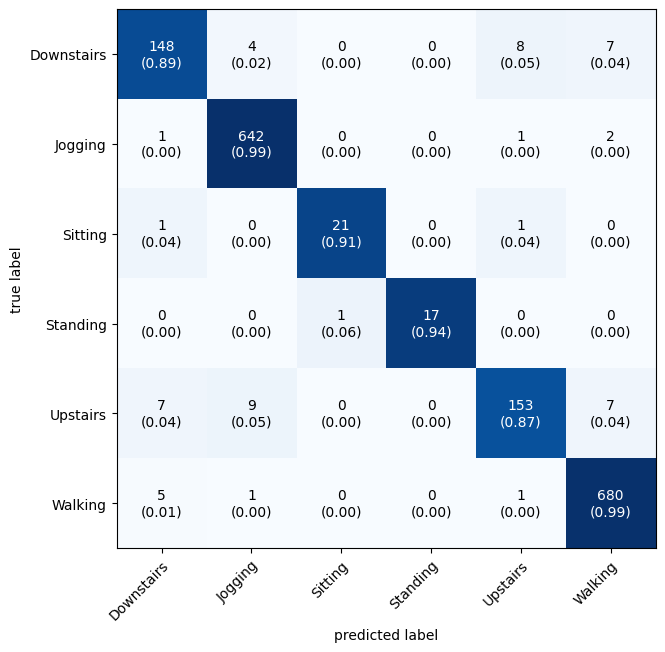

In [35]:
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

## LSTM Model

In [36]:
lstm_model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50, batch_size=64
)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9268 - loss: 0.1955 - val_accuracy: 0.8959 - val_loss: 0.3034
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9196 - loss: 0.2072 - val_accuracy: 0.8981 - val_loss: 0.2854
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9132 - loss: 0.2238 - val_accuracy: 0.9076 - val_loss: 0.2686
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9299 - loss: 0.1921 - val_accuracy: 0.9134 - val_loss: 0.2588
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9389 - loss: 0.1770 - val_accuracy: 0.9258 - val_loss: 0.2527
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9262 - loss: 0.1899 - val_accuracy: 0.9141 - val_loss: 0.2821
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9282 - loss: 0.2001 - val_accuracy: 0.9243 - val_loss: 0.2386
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9368 - loss: 0.1703 - val_accuracy: 0.9119 - val_loss

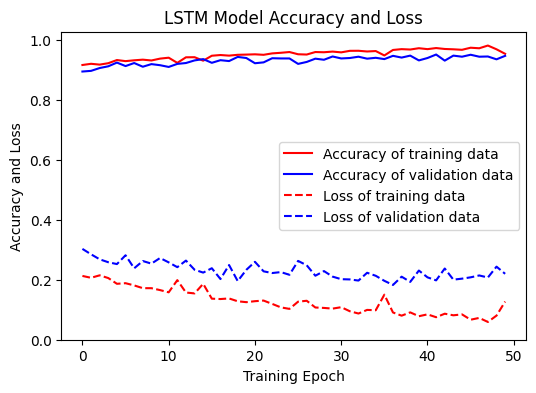

In [43]:
plt.figure(figsize=(6, 4))
plt.plot(lstm_history.history["accuracy"], 'r', label = "Accuracy of training data")
plt.plot(lstm_history.history["val_accuracy"], 'b', label = "Accuracy of validation data")
plt.plot(lstm_history.history["loss"], 'r--', label = "Loss of training data")
plt.plot(lstm_history.history["val_loss"], 'b--', label = "Loss of validation data")
plt.title("LSTM Model Accuracy and Loss")
plt.ylabel("Accuracy and Loss")
plt.xlabel("Training Epoch")
plt.ylim(0)
plt.legend()
plt.show()


In [44]:
predicted =lstm_model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


              precision    recall  f1-score   support

           0       0.81      0.80      0.80       167
           1       0.99      1.00      0.99       646
           2       0.96      0.96      0.96        23
           3       1.00      0.89      0.94        18
           4       0.85      0.84      0.84       176
           5       0.97      0.98      0.97       687

    accuracy                           0.95      1717
   macro avg       0.93      0.91      0.92      1717
weighted avg       0.95      0.95      0.95      1717



(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

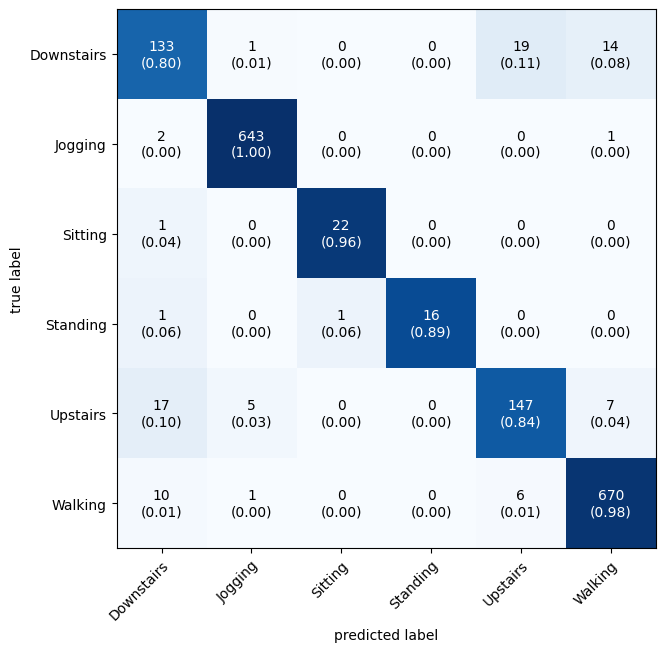

In [45]:
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

## CNN-LSTM Model

In [52]:
from tensorflow.keras.layers import TimeDistributed
X_train_cl = X_train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]))
X_test_cl  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1], X_test.shape[2]))

cnn_lstm_model = Sequential([
    TimeDistributed(
        Conv1D(32, 3, activation='relu'),
        input_shape=(1, frame_size, 3)
    ),
    TimeDistributed(MaxPooling1D(2)),
    TimeDistributed(Flatten()),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
cnn_lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [53]:
cnn_lstm_history = cnn_lstm_model.fit(X_train_cl, y_train, epochs = 30, validation_split = 0.2, verbose=1)

Epoch 1/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7085 - loss: 0.8785 - val_accuracy: 0.8297 - val_loss: 0.4379
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8567 - loss: 0.3747 - val_accuracy: 0.8836 - val_loss: 0.3005
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9145 - loss: 0.2308 - val_accuracy: 0.9163 - val_loss: 0.2625
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9577 - loss: 0.1270 - val_accuracy: 0.9374 - val_loss: 0.2068
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9805 - loss: 0.0732 - val_accuracy: 0.9403 - val_loss: 0.2021
Epoch 6/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9914 - loss: 0.0442 - val_accuracy: 0.9476 - val_loss: 0.2011
Epoch 7/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9966 - loss: 0.0204 - val_accuracy: 0.9389 - val_loss: 0.2167
Epoch 8/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 0.0105 - val_accuracy: 0.

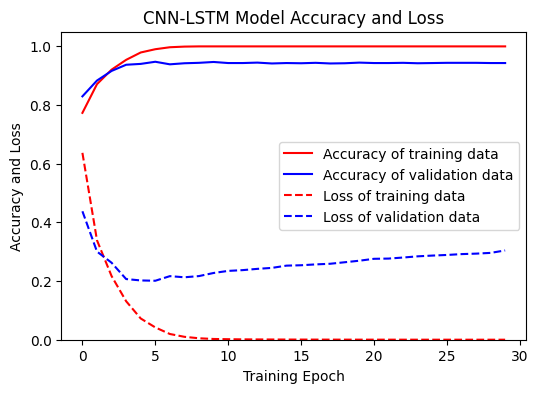

In [54]:
plt.figure(figsize=(6, 4))
plt.plot(cnn_lstm_history.history["accuracy"], 'r', label = "Accuracy of training data")
plt.plot(cnn_lstm_history.history["val_accuracy"], 'b', label = "Accuracy of validation data")
plt.plot(cnn_lstm_history.history["loss"], 'r--', label = "Loss of training data")
plt.plot(cnn_lstm_history.history["val_loss"], 'b--', label = "Loss of validation data")
plt.title("CNN-LSTM Model Accuracy and Loss")
plt.ylabel("Accuracy and Loss")
plt.xlabel("Training Epoch")
plt.ylim(0)
plt.legend()
plt.show()


In [55]:
predicted =cnn_lstm_model.predict(X_test_cl)
y_pred = predicted.argmax(axis=-1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


              precision    recall  f1-score   support

           0       0.87      0.72      0.79       167
           1       0.97      0.99      0.98       646
           2       0.96      0.96      0.96        23
           3       1.00      0.94      0.97        18
           4       0.81      0.81      0.81       176
           5       0.96      0.99      0.97       687

    accuracy                           0.94      1717
   macro avg       0.93      0.90      0.91      1717
weighted avg       0.94      0.94      0.94      1717



(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

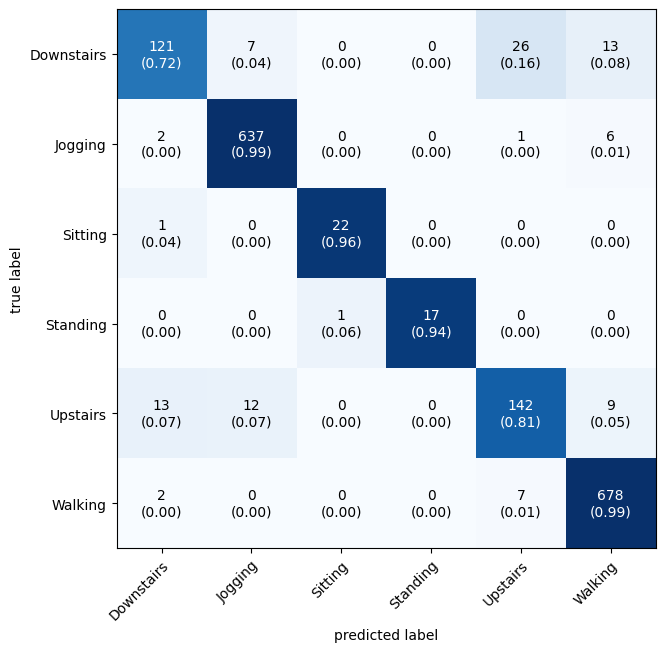

In [56]:
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))